# New IMPLEMENTATION of the CNN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# Import the scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Import functional for the custom loss
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import traceback
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
# For the moment those are some random hyper parameter, in the futur we will train them with optuna. 

device = torch.device("cpu") # just to be sure we send the model to the right device, ofc no CUDA since we are on macbook,
#might need to be updated if we use the Virtual Machine.

SOURCE_IMAGE_FOLDER = '//Users/pacohoche/Desktop/harmonic/MYTEST' # importing My TEST folder with all different pictures.

BATCH_SIZE = 32
LEARNING_RATE = 5e-5
NUM_EPOCHS = 25
EMBEDDING_DIM = 256


In [ ]:
class ImageColumnKLDivLoss(nn.Module):
    def __init__(self, epsilon: float = 1e-8): #increased epsilon 
        super().__init__()
        self.epsilon = epsilon
    
    def forward(self, predicted: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Calculate KL divergence loss between columns of two image tensors.
        
        :param predicted: Tensor of shape (batch_size, 1, height, width)
        :param target: Tensor of shape (batch_size, 1, height, width)
        :return: scalar loss value
        """
        # Ensure inputs are positive
        predicted = torch.clamp(predicted, min=0.0)
        target = torch.clamp(target, min=0.0)
        
        # Add epsilon and ensure numerical stability
        predicted = predicted + self.epsilon
        target = target + self.epsilon
        
        # Normalize along height dimension
        pred_sum = predicted.sum(dim=2, keepdim=True)
        target_sum = target.sum(dim=2, keepdim=True)
        
        # Avoid division by zero
        pred_norm = predicted / torch.clamp(pred_sum, min=self.epsilon)
        target_norm = target / torch.clamp(target_sum, min=self.epsilon)
        
        # Calculate KL divergence
        kl_div = F.kl_div(
            (pred_norm + self.epsilon).log(),
            target_norm,
            reduction='none'
        )
        
        # Check for NaN values and replace with zeros
        kl_div = torch.nan_to_num(kl_div, 0.0)
        
        # Sum over height and average over batch and width
        loss = kl_div.sum(dim=2).mean()
        
        return loss

In [ ]:
class ImageTimeSeriesDatasetSingleFolder(Dataset):
    def __init__(self, source_dir, transform=None):
        self.source_dir = source_dir
        self.transform = transform
        
        self.filenames = sorted([
            f for f in os.listdir(source_dir) 
            if os.path.isfile(os.path.join(source_dir, f)) 
               and f.lower().endswith('.png')
        ])
        if not self.filenames:
            raise FileNotFoundError(f"No PNG image files found in {source_dir}.")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.source_dir, self.filenames[idx])
        
        # Load grayscale image
        original_image = Image.open(img_name).convert('L')

        # Apply transform if provided, else just convert to tensor
        if self.transform:
            full_tensor = self.transform(original_image)  # [C, H, W]
        else:
            full_tensor = transforms.ToTensor()(original_image)  # [1, H, W]

        # Compute width
        _, _, width = full_tensor.shape

        # Indices for the 70% slices along the horizontal axis
        input_end   = int(0.7 * width)  # end for the input portion
        target_start = int(0.3 * width)  # start for the target portion

        # Slice the input (first 70%) and target (last 70%)
        input_tensor  = full_tensor[:, :, :input_end]
        target_tensor = full_tensor[:, :, target_start:]

        return input_tensor, target_tensor



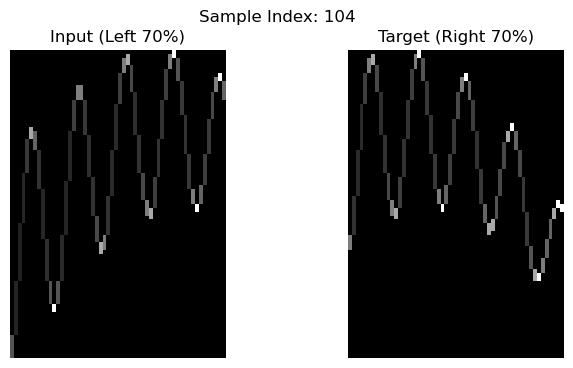

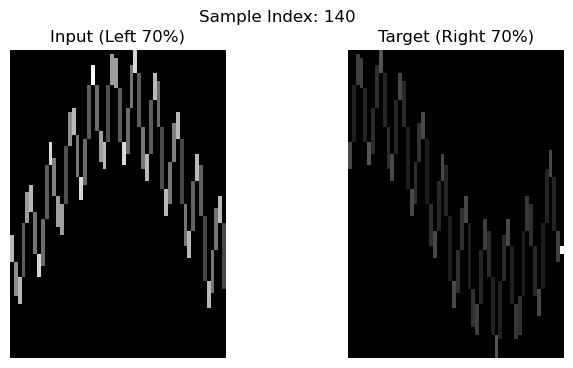

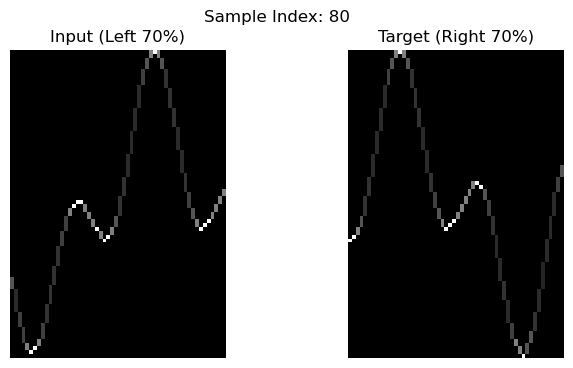

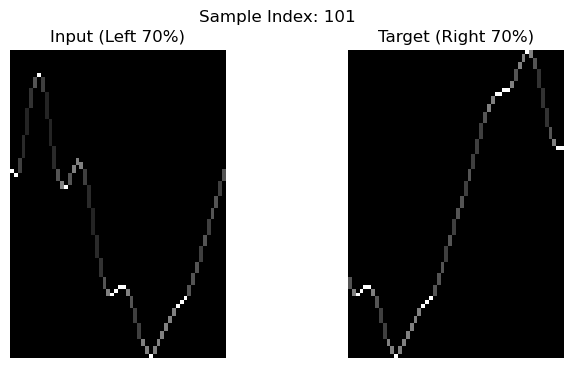

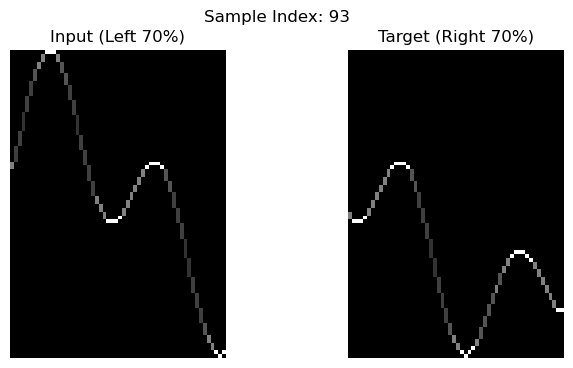

In [ ]:
# A TEST FONCTION TO VISUALIZE THE DATASET AND OUR 70 PERCENT CUT 
import random
import matplotlib.pyplot as plt

def show_random_samples(dataset, num_samples=5):
    """
    Displays 'num_samples' random examples from the dataset.
    Each example is displayed in its own figure with two subplots:
    - Left: the input portion (left 70%)
    - Right: the target portion (right 70%)
    """
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, idx in enumerate(indices):
        input_tensor, target_tensor = dataset[idx]
        
        # input_tensor & target_tensor shape: [1, H, W]
        # Convert them to numpy arrays
        input_img = input_tensor.squeeze().numpy()
        target_img = target_tensor.squeeze().numpy()
        
        # Create a new figure for each sample
        plt.figure(figsize=(8,4))
        
        # Plot the input slice
        plt.subplot(1, 2, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input (Left 70%)')
        plt.axis('off')
        
        # Plot the target slice
        plt.subplot(1, 2, 2)
        plt.imshow(target_img, cmap='gray')
        plt.title('Target (Right 70%)')
        plt.axis('off')
        
        plt.suptitle(f"Sample Index: {idx}", fontsize=12)
        plt.show()


dataset_test_plot = ImageTimeSeriesDatasetSingleFolder("//Users/pacohoche/Desktop/harmonic/MYTEST")

show_random_samples(dataset_test_plot, num_samples=5)


The fonction above just does two things: 
1) transform the images and put them into tensors
2) create the input image we want, so an image that has dimension 80x60, and the rest of it is black. 

to be checked in the futur maybe, in the first implementation they use "unsqueeze(0)" which change the dimension of the tensor, but we can not use it now or it would change everything. so maybe investigate it. 


In [ ]:
## VISUAL AE FOR VARIABLE DIMENSIONS
import torch
import torch.nn as nn

class VisualAE_variablesize(nn.Module):
    """
    A fully convolutional Autoencoder designed to handle variable input image sizes.
    It encodes the input image into a feature map and then decodes it back.
    The convolutional parameters (kernel, stride, padding) are kept consistent
    with the original fixed-size version.
    """
    def __init__(self):
        # No embedding_dim needed here as the bottleneck is a feature map
        super(VisualAE_variablesize, self).__init__()

        # --- Encoder ---
        # Takes variable size [B, 1, H, W] input
        self.encoder_conv = nn.Sequential(
            # Layer 1: [B, 1, H, W] -> [B, 64, H/2, W/2] (approx)
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Layer 2: [B, 64, H/2, W/2] -> [B, 128, H/4, W/4] (approx)
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Layer 3: [B, 128, H/4, W/4] -> [B, 512, H/8, W/8] (approx)
            nn.Conv2d(128, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
            # Output is the bottleneck feature map
        )

        # --- Decoder ---
        # Takes variable size [B, 512, H_bottleneck, W_bottleneck] input
        self.decoder_conv = nn.Sequential(
            # Layer 1: [B, 512, H/8, W/8] -> [B, 128, H/4, W/4] (approx)
            # Note: output_padding=1 helps align dimensions when stride=2 doubles the size
            nn.ConvTranspose2d(512, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Layer 2: [B, 128, H/4, W/4] -> [B, 64, H/2, W/2] (approx)
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Layer 3: [B, 64, H/2, W/2] -> [B, 1, H, W] (approx)
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid() # Output pixel values between 0 and 1
        )

    def encode(self, x):
        
        embedding_map = self.encoder_conv(x)
        return embedding_map

    def decode(self, embedding_map):
        
        reconstruction = self.decoder_conv(embedding_map)
        return reconstruction

    def forward(self, x):
        embedding_map = self.encode(x)
        reconstruction = self.decode(embedding_map)
        return reconstruction

The collate fonction allows us to combine individual samples from the folderdataset  into a batch, which will later passe to the model during training and evalutation.  

In [ ]:
def pad_collate_fn(batch):
    """
    Pads images in a batch to the maximum height and width found in that batch.
    Handles separate padding for input and target tensors if their max widths differ.
    Assumes input tensors are of shape [1, H, W_in] and targets [1, H, W_tgt].
    """
    # Filter out None values potentially returned by __getitem__ on error
    batch = [item for item in batch if item[0] is not None and item[1] is not None]
    if not batch:
        # Return empty tensors or raise error if batch is empty after filtering
        # Need to return tensors with expected number of dimensions for unpacking later
        return torch.empty((0, 1, 1, 1)), torch.empty((0, 1, 1, 1))

    # batch: List of [ (input_tensor [1,H,W_in], target_tensor [1,H,W_tgt]) ]
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Find max height across all tensors in the batch (height is dimension 1)
    max_h = max(max(inp.shape[1] for inp in inputs), max(tgt.shape[1] for tgt in targets))

    # Find max width separately for inputs and targets across the batch (width is dim 2)
    max_w_in = max(inp.shape[2] for inp in inputs)
    max_w_tgt = max(tgt.shape[2] for tgt in targets)

    padded_inputs = []
    for inp in inputs:
        # inp shape: [1, H, W_in]
        pad_h = max_h - inp.shape[1] # Padding for height (bottom)
        pad_w = max_w_in - inp.shape[2] # Padding for width (right)
        # F.pad format: (pad_left, pad_right, pad_top, pad_bottom) for last 2 dims
        # We have dims [C, H, W] -> need padding for W then H
        # (pad_left, pad_right, pad_top, pad_bottom) -> (0, pad_w, 0, pad_h)
        padded_inp = F.pad(inp, (0, pad_w, 0, pad_h), "constant", 0)
        padded_inputs.append(padded_inp)

    padded_targets = []
    for tgt in targets:
        # tgt shape: [1, H, W_tgt]
        pad_h = max_h - tgt.shape[1] # Padding for height (bottom)
        pad_w = max_w_tgt - tgt.shape[2] # Padding for width (right)
        padded_tgt = F.pad(tgt, (0, pad_w, 0, pad_h), "constant", 0)
        padded_targets.append(padded_tgt)

    # Stack tensors into batches -> [B, 1, max_H, max_W]
    input_batch = torch.stack(padded_inputs)
    target_batch = torch.stack(padded_targets)

    return input_batch, target_batch

## This fonction is change from the usual collate_fn to pad the input and target tensors to the same height and width
## THIS IS BECAUSE WE CREATED THE PIPELINE FOR VARIABLE SIZE IMAGES 

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [58]:
transform = None  # or transforms.Compose([...]) if desired
dataset = ImageTimeSeriesDatasetSingleFolder(SOURCE_IMAGE_FOLDER, transform=transform)

# Use the pad_collate_fn here
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=pad_collate_fn,  # <<< USE PADDING COLLATE FN
)
print("DataLoader initialized.")


DataLoader initialized.


In [60]:
# --- Initialize dataset ---
try:
    dataset = ImageTimeSeriesDatasetSingleFolder(source_dir=SOURCE_IMAGE_FOLDER)
    print(f"Dataset initialized with {len(dataset)} images.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the SOURCE_IMAGE_FOLDER path is correct.")
    exit()
except Exception as e:
    print(f"An error occurred during dataset initialization: {e}")
    exit()

# --- Initialize model, optimizer, and loss function ---
model = VisualAE_variablesize().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = ImageColumnKLDivLoss().to(device) 

# --- Training Loop ---
print("Starting training...")
train_loss_list = []
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    num_batches = 0

    
    for batch_data in dataloader:
        # The dataloader now yields (input_batch, target_batch)
        input_batch, target_batch = batch_data

        # Skip batch if empty (can happen if all items failed in __getitem__ and were filtered)
        if input_batch.nelement() == 0 or target_batch.nelement() == 0:
             print("Skipping empty batch")
             continue

        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device) # Move target if needed by loss/comparison

        # Forward pass
        recon_batch = model(input_batch) # Model reconstructs the input

        

        # Prediction Loss (Compare recon to the target_batch - last 70%)
        loss = criterion(recon_batch, target_batch) 
        # FOR FUTUR : ImageColumnKLDivLoss handles potential shape mismatches ? 

        # Backward pass and optimize
        optimizer.zero_grad()
        # Handle potential gradient issues
        if torch.isfinite(loss):
             loss.backward()
             optimizer.step()
        else:
             print(f"Warning: Skipping optimizer step due to non-finite loss in Epoch {epoch+1}, Batch {num_batches+1}")


        # Accumulate loss
        if torch.isfinite(loss): # Only accumulate finite loss
            running_loss += loss.item() * input_batch.size(0)
        num_batches += 1

    # Calculate epoch loss
    if len(dataset) > 0:
         epoch_loss = running_loss / len(dataset) # Average loss per sample
         train_loss_list.append(epoch_loss)
         print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.6f}") # Increased precision
    else:
         print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], No data processed.")


print("Training complete!")

# --- Plot the training loss ---
if train_loss_list: # Only plot if list is not empty
    plt.figure()
    plt.plot(train_loss_list)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
else:
    print("No training loss recorded to plot.")

# --- Visualize 5 input vs reconstructed images ---
print("Visualizing sample reconstructions...")
if len(dataset) > 0: # Only visualize if there's data
    model.eval()
    with torch.no_grad():
        try:
            # Grab one batch of data using an iterator
            data_iter = iter(dataloader)
            # <<< FIX: Unpack the batch correctly >>>
            input_batch, target_batch = next(data_iter)

            if input_batch.nelement() > 0:
                # <<< FIX: Move input_batch to device >>>
                sample_images = input_batch.to(device)

                # Forward pass to get reconstruction
                recon_images = model(sample_images)

                # Show 'num_to_show' images (or fewer if batch is smaller)
                num_to_show = min(5, sample_images.size(0))
                input_images_to_show = sample_images[:num_to_show]
                output_images_to_show = recon_images[:num_to_show]
                # If you want to show the target (last 70%) as well:
                # target_images_to_show = target_batch[:num_to_show]

                # Concatenate input and reconstructed images for display
                # Ensure they have the same size for make_grid - they should if recon matches input
                combined = torch.cat([input_images_to_show, output_images_to_show], dim=0)

                # Create a grid: num_to_show columns, 2 rows
                grid = make_grid(combined, nrow=num_to_show)

                plt.figure(figsize=(num_to_show * 2, 5)) # Adjust figure size
                # Convert the grid to CPU numpy HWC format for plotting
                plt.imshow(grid.permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray') # Added squeeze for grayscale
                plt.title('Top: Input (First 70%) | Bottom: Reconstructed')
                plt.axis('off')
                plt.show()
            else:
                print("Could not retrieve a valid batch for visualization.")

        except StopIteration:
            print("DataLoader is empty, cannot visualize.")
        except Exception as e:
            print(f"An error occurred during visualization: {e}")
            print(traceback.format_exc())
else:
    print("Dataset is empty, skipping visualization.")

Dataset initialized with 200 images.
Starting training...
Epoch [1/25], Loss: 1.794413
Epoch [2/25], Loss: 1.681371
Epoch [3/25], Loss: 1.633576


KeyboardInterrupt: 

In [28]:
from torchvision.utils import make_grid